# Project 2 -- Reinforcement Learning and Decision Makeing

## Goal & Requirements

在“格子世界”中，含有四个障碍、一个起点及一个终点，是一个正方形格子迷宫，迷宫大小可让每位同学根据自己的计算机能力而定；根据理论教学及网上资料，实现强化学习的最基本框架：贝尔曼方程和Q函数；基本要求为学生在IDE平台下自己运行已有的Q-Learning框架并理解、调整参数设定，有余力的同学可自己实现Q-Learning基础算法；使用该框架或算法运行以上“格子世界”游戏，观察智能的“软件小机器人”是否可以达到目的地，以及达到目的地的时间；将实验数据统计、作图展示。



## Attempt 1 : Grid World

### Source  

https://github.com/kevin-hanselman/grid-world-rl


### Introduction

Grid World 是GitHub上一个开源格子世界。可以自己设定障碍物的位置，得分点和扣分点，要尽可能得更多的分。同时程序也已经实现了Q-Learning算法，可以自己调整参数设定，并观察智能的“软件小机器人”的得分。

由于这次课程设计需要调整参数，所以在开源代码的基础上，我修改了一部分代码，方便调参。



### Code

##### Part 1 : Grid World


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings("ignore")

class GridWorldMDP:

    # up, right, down, left
    _direction_deltas = [
        (-1, 0),
        (0, 1),
        (1, 0),
        (0, -1),
    ]
    _num_actions = len(_direction_deltas)

    def __init__(self,
                 reward_grid,
                 terminal_mask,
                 obstacle_mask,
                 action_probabilities,
                 no_action_probability):

        self._reward_grid = reward_grid
        self._terminal_mask = terminal_mask
        self._obstacle_mask = obstacle_mask
        self._T = self._create_transition_matrix(
            action_probabilities,
            no_action_probability,
            obstacle_mask
        )

    @property
    def shape(self):
        return self._reward_grid.shape

    @property
    def size(self):
        return self._reward_grid.size

    @property
    def reward_grid(self):
        return self._reward_grid

    def run_value_iterations(self, discount=1.0,
                             iterations=10):
        utility_grids, policy_grids = self._init_utility_policy_storage(iterations)

        utility_grid = np.zeros_like(self._reward_grid)
        for i in range(iterations):
            utility_grid = self._value_iteration(utility_grid=utility_grid)
            policy_grids[:, :, i] = self.best_policy(utility_grid)
            utility_grids[:, :, i] = utility_grid
        return policy_grids, utility_grids

    def run_policy_iterations(self, discount=1.0,
                              iterations=10):
        utility_grids, policy_grids = self._init_utility_policy_storage(iterations)

        policy_grid = np.random.randint(0, self._num_actions,
                                        self.shape)
        utility_grid = self._reward_grid.copy()

        for i in range(iterations):
            policy_grid, utility_grid = self._policy_iteration(
                policy_grid=policy_grid,
                utility_grid=utility_grid
            )
            policy_grids[:, :, i] = policy_grid
            utility_grids[:, :, i] = utility_grid
        return policy_grids, utility_grids

    def generate_experience(self, current_state_idx, action_idx):
        sr, sc = self.grid_indices_to_coordinates(current_state_idx)
        next_state_probs = self._T[sr, sc, action_idx, :, :].flatten()

        next_state_idx = np.random.choice(np.arange(next_state_probs.size),
                                          p=next_state_probs)

        return (next_state_idx,
                self._reward_grid.flatten()[next_state_idx],
                self._terminal_mask.flatten()[next_state_idx])

    def grid_indices_to_coordinates(self, indices=None):
        if indices is None:
            indices = np.arange(self.size)
        return np.unravel_index(indices, self.shape)

    def grid_coordinates_to_indices(self, coordinates=None):
        # Annoyingly, this doesn't work for negative indices.
        # The mode='wrap' parameter only works on positive indices.
        if coordinates is None:
            return np.arange(self.size)
        return np.ravel_multi_index(coordinates, self.shape)

    def best_policy(self, utility_grid):
        M, N = self.shape
        return np.argmax((utility_grid.reshape((1, 1, 1, M, N)) * self._T)
                         .sum(axis=-1).sum(axis=-1), axis=2)

    def _init_utility_policy_storage(self, depth):
        M, N = self.shape
        utility_grids = np.zeros((M, N, depth))
        policy_grids = np.zeros_like(utility_grids)
        return utility_grids, policy_grids

    def _create_transition_matrix(self,
                                  action_probabilities,
                                  no_action_probability,
                                  obstacle_mask):
        M, N = self.shape

        T = np.zeros((M, N, self._num_actions, M, N))

        r0, c0 = self.grid_indices_to_coordinates()

        T[r0, c0, :, r0, c0] += no_action_probability

        for action in range(self._num_actions):
            for offset, P in action_probabilities:
                direction = (action + offset) % self._num_actions

                dr, dc = self._direction_deltas[direction]
                r1 = np.clip(r0 + dr, 0, M - 1)
                c1 = np.clip(c0 + dc, 0, N - 1)

                temp_mask = obstacle_mask[r1, c1].flatten()
                r1[temp_mask] = r0[temp_mask]
                c1[temp_mask] = c0[temp_mask]

                T[r0, c0, action, r1, c1] += P

        terminal_locs = np.where(self._terminal_mask.flatten())[0]
        T[r0[terminal_locs], c0[terminal_locs], :, :, :] = 0
        return T

    def _value_iteration(self, utility_grid, discount=1.0):
        out = np.zeros_like(utility_grid)
        M, N = self.shape
        for i in range(M):
            for j in range(N):
                out[i, j] = self._calculate_utility((i, j),
                                                    discount,
                                                    utility_grid)
        return out

    def _policy_iteration(self, *, utility_grid,
                          policy_grid, discount=1.0):
        r, c = self.grid_indices_to_coordinates()

        M, N = self.shape

        utility_grid = (
            self._reward_grid +
            discount * ((utility_grid.reshape((1, 1, 1, M, N)) * self._T)
                        .sum(axis=-1).sum(axis=-1))[r, c, policy_grid.flatten()]
            .reshape(self.shape)
        )

        utility_grid[self._terminal_mask] = self._reward_grid[self._terminal_mask]

        return self.best_policy(utility_grid), utility_grid

    def _calculate_utility(self, loc, discount, utility_grid):
        if self._terminal_mask[loc]:
            return self._reward_grid[loc]
        row, col = loc
        return np.max(
            discount * np.sum(
                np.sum(self._T[row, col, :, :, :] * utility_grid,
                       axis=-1),
                axis=-1)
        ) + self._reward_grid[loc]

    def plot_policy(self, utility_grid, policy_grid=None):
        if policy_grid is None:
            policy_grid = self.best_policy(utility_grid)
        markers = "^>v<"
        marker_size = 200 // np.max(policy_grid.shape)
        marker_edge_width = marker_size // 10
        marker_fill_color = 'w'

        no_action_mask = self._terminal_mask | self._obstacle_mask

        utility_normalized = (utility_grid - utility_grid.min()) / \
                             (utility_grid.max() - utility_grid.min())

        utility_normalized = (255*utility_normalized).astype(np.uint8)

        utility_rgb = cv2.applyColorMap(utility_normalized, cv2.COLORMAP_JET)
        for i in range(3):
            channel = utility_rgb[:, :, i]
            channel[self._obstacle_mask] = 0

        plt.imshow(utility_rgb[:, :, ::-1], interpolation='none')

        for i, marker in enumerate(markers):
            y, x = np.where((policy_grid == i) & np.logical_not(no_action_mask))
            plt.plot(x, y, marker, ms=marker_size, mew=marker_edge_width,
                     color=marker_fill_color)

        y, x = np.where(self._terminal_mask)
        plt.plot(x, y, 'o', ms=marker_size, mew=marker_edge_width,
                 color=marker_fill_color)

        tick_step_options = np.array([1, 2, 5, 10, 20, 50, 100])
        tick_step = np.max(policy_grid.shape)/8
        best_option = np.argmin(np.abs(np.log(tick_step) - np.log(tick_step_options)))
        tick_step = tick_step_options[best_option]
        plt.xticks(np.arange(0, policy_grid.shape[1] - 0.5, tick_step))
        plt.yticks(np.arange(0, policy_grid.shape[0] - 0.5, tick_step))
        plt.xlim([-0.5, policy_grid.shape[0]-0.5])
        plt.xlim([-0.5, policy_grid.shape[1]-0.5])





##### Part 2 : Q-Learning


In [2]:
import numpy as np
import random as rand


class QLearner:
    '''A generic implementation of Q-Learning and Dyna-Q'''

    def __init__(self, *,
                 num_states,
                 num_actions,
                 learning_rate,
                 discount_rate=1.0,
                 random_action_prob=0.5,
                 random_action_decay_rate=0.99,
                 dyna_iterations=0):

        self._num_states = num_states
        self._num_actions = num_actions
        self._learning_rate = learning_rate
        self._discount_rate = discount_rate
        self._random_action_prob = random_action_prob
        self._random_action_decay_rate = random_action_decay_rate
        self._dyna_iterations = dyna_iterations

        self._experiences = []

        # Initialize Q to small random values.
        self._Q = np.zeros((num_states, num_actions), dtype=np.float)
        self._Q += np.random.normal(0, 0.3, self._Q.shape)

    def initialize(self, state):
        '''Set the initial state and return the learner's first action'''
        self._decide_next_action(state)
        self._stored_state = state
        return self._stored_action

    def learn(self, initial_state, experience_func, iterations=100):
        '''Iteratively experience new states and rewards'''
        all_policies = np.zeros((self._num_states, iterations))
        all_utilities = np.zeros_like(all_policies)
        for i in range(iterations):
            done = False
            self.initialize(initial_state)
            for j in range(iterations):
                state, reward, done = experience_func(self._stored_state,
                                                      self._stored_action)
                self.experience(state, reward)
                if done:
                    break

            policy, utility = self.get_policy_and_utility()
            all_policies[:, i] = policy
            all_utilities[:, i] = utility
        return all_policies, all_utilities

    def experience(self, state, reward):
        '''The learner experiences state and receives a reward'''
        self._update_Q(self._stored_state, self._stored_action, state, reward)

        if self._dyna_iterations > 0:
            self._experiences.append(
                (self._stored_state, self._stored_action, state, reward)
            )
            exp_idx = np.random.choice(len(self._experiences),
                                       self._dyna_iterations)
            for i in exp_idx:
                self._update_Q(*self._experiences[i])

        # determine an action and update the current state
        self._decide_next_action(state)
        self._stored_state = state

        self._random_action_prob *= self._random_action_decay_rate

        return self._stored_action

    def get_policy_and_utility(self):
        policy = np.argmax(self._Q, axis=1)
        utility = np.max(self._Q, axis=1)
        return policy, utility

    def _update_Q(self, s, a, s_prime, r):
        best_reward = self._Q[s_prime, self._find_best_action(s_prime)]
        self._Q[s, a] *= (1 - self._learning_rate)
        self._Q[s, a] += (self._learning_rate
                          * (r + self._discount_rate * best_reward))

    def _decide_next_action(self, state):
        if rand.random() <= self._random_action_prob:
            self._stored_action = rand.randint(0, self._num_actions - 1)
        else:
            self._stored_action = self._find_best_action(state)

    def _find_best_action(self, state):
        return int(np.argmax(self._Q[state, :]))




##### Part 3 : Visualization



In [4]:
import numpy as np
import matplotlib.pyplot as plt


def plot_convergence(utility_grids, policy_grids):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    utility_ssd = np.sum(np.square(np.diff(utility_grids)), axis=(0, 1))
    ax1.plot(utility_ssd, 'b.-')
    ax1.set_ylabel('Change in Utility', color='b')

    policy_changes = np.count_nonzero(np.diff(policy_grids), axis=(0, 1))
    ax2.plot(policy_changes, 'r.-')
    ax2.set_ylabel('Change in Best Policy', color='r')


def MainProgram(default_reward=-0.03,learning_rate=0.8,iterations=50000,OnlyQlearning=False):

    # 地图设定一次，后续不做修改，为了方便比较、控制变量
    # 修改源程序 使得可以增加多个障碍物
    shape = (4,4)
    goals = [(3,3),(0,3),(2,1)]
    traps = [(1,1),(3,0)]
    obstacles = [(2,2),(1,2)]
    start = (0, 0)
    goal_reward = 1
    trap_reward = -1

    reward_grid = np.zeros(shape) + default_reward

    for goal in goals :
        reward_grid[goal] = goal_reward
    for trap in traps :
        reward_grid[trap] = trap_reward
    for obstacle in obstacles :
        reward_grid[obstacle] = 0

    terminal_mask = np.zeros_like(reward_grid, dtype=np.bool)
    for goal in goals :
        terminal_mask[goal] = True
    for trap in traps :
        terminal_mask[trap] = True

    obstacle_mask = np.zeros_like(reward_grid, dtype=np.bool)
    for obstacle in obstacles :
        obstacle_mask[obstacle] = True

    gw = GridWorldMDP(reward_grid=reward_grid,
                      obstacle_mask=obstacle_mask,
                      terminal_mask=terminal_mask,
                      action_probabilities=[
                          (-1, 0.1),
                          (0, 0.8),
                          (1, 0.1),
                      ],
                      no_action_probability=0.0)

    mdp_solvers = {'Value Iteration': gw.run_value_iterations(iterations=iterations),
                   'Policy Iteration': gw.run_policy_iterations(iterations=iterations)}
    if OnlyQlearning == False:
        for solver_name, solver_fn in mdp_solvers.items():
            print('Final result of {}:'.format(solver_name))
            policy_grids, utility_grids = solver_fn
            print(policy_grids[:, :, -1])
            print(utility_grids[:, :, -1])
            plt.figure()
            gw.plot_policy(utility_grids[:, :, -1])
            plot_convergence(utility_grids, policy_grids)
            plt.show()

    ql = QLearner(num_states=(shape[0] * shape[1]),
                  num_actions=4,
                  learning_rate=learning_rate,
                  discount_rate=0.9,
                  random_action_prob=0.5,
                  random_action_decay_rate=0.99,
                  dyna_iterations=0)

    start_state = gw.grid_coordinates_to_indices(start)

    iterations = iterations

    flat_policies, flat_utilities = ql.learn(start_state,
                                             gw.generate_experience,
                                             iterations=iterations)

    new_shape = (gw.shape[0], gw.shape[1], iterations)
    ql_utility_grids = flat_utilities.reshape(new_shape)
    ql_policy_grids = flat_policies.reshape(new_shape)
    print('Final result of QLearning:')
    print(ql_policy_grids[:, :, -1])
    print(ql_utility_grids[:, :, -1])

    plt.figure()
    gw.plot_policy(ql_utility_grids[:, :, -1], ql_policy_grids[:, :, -1])
    plot_convergence(ql_utility_grids, ql_policy_grids)
    plt.show()


##### Part 4 :Arguments Adjustment

地图设定：
从左上角$(0,0)$出发。

障碍：全为黑色。$(1,2),(2,2)$

陷阱：$(1,1),(3,0)$

奖励：$(0,3),(3,3),(2,1)$

奖惩分数：陷阱-1，奖励1，障碍物不能走。

##### Default_Reward and Learnin Rate Adjustment

Final result of Value Iteration:
[[1. 1. 1. 0.]
 [3. 0. 1. 0.]
 [1. 0. 3. 2.]
 [0. 1. 1. 0.]]
[[ 0.6589372   0.71111111  0.9625      1.        ]
 [ 0.54154589 -1.          0.9625      0.9625    ]
 [ 0.72415459  1.          0.99583333  0.9625    ]
 [-1.          0.93333333  0.9625      1.        ]]


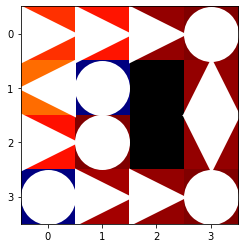

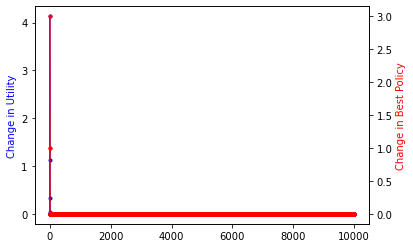

Final result of Policy Iteration:
[[1. 1. 1. 0.]
 [3. 0. 1. 0.]
 [1. 0. 3. 2.]
 [0. 1. 1. 0.]]
[[ 0.6589372   0.71111111  0.9625      1.        ]
 [ 0.54154589 -1.          0.9625      0.9625    ]
 [ 0.72415459  1.          0.99583333  0.9625    ]
 [-1.          0.93333333  0.9625      1.        ]]


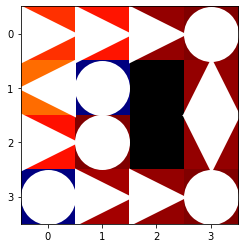

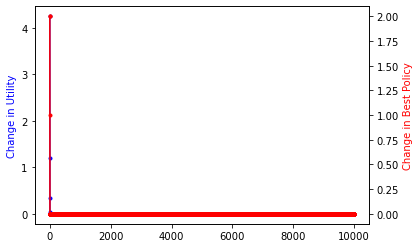

Final result of QLearning:
[[1. 0. 1. 2.]
 [3. 1. 2. 3.]
 [0. 3. 0. 0.]
 [3. 2. 1. 3.]]
[[ 0.55538624  0.93470978  1.15617543  0.20004082]
 [-0.00372887  0.16253522  0.05343843  0.37296264]
 [-0.08566748  0.09629288  0.46828838  0.13058414]
 [ 0.28226109  0.46069259  0.1996232   0.6030493 ]]


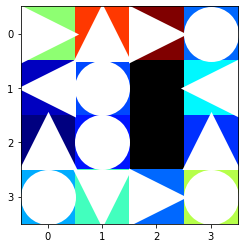

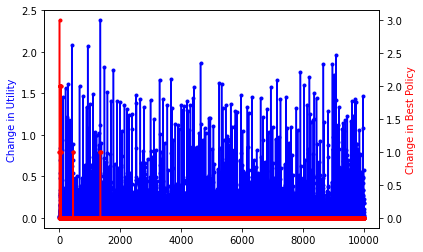

In [5]:
# 对照组

default_reward = -0.03
learning_rate = 0.8
iterations =10000
MainProgram(default_reward,learning_rate,iterations)

Final result of Value Iteration:
[[1. 1. 1. 0.]
 [3. 0. 1. 0.]
 [1. 0. 3. 2.]
 [0. 1. 1. 0.]]
[[ 0.6589372   0.71111111  0.9625      1.        ]
 [ 0.54154589 -1.          0.9625      0.9625    ]
 [ 0.72415459  1.          0.99583333  0.9625    ]
 [-1.          0.93333333  0.9625      1.        ]]


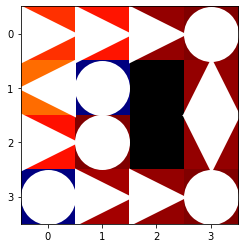

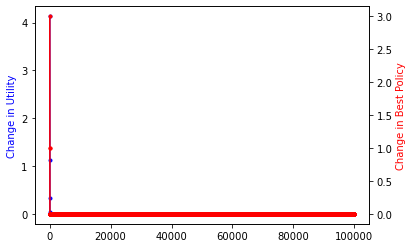

Final result of Policy Iteration:
[[1. 1. 1. 0.]
 [3. 0. 1. 0.]
 [1. 0. 3. 2.]
 [0. 1. 1. 0.]]
[[ 0.6589372   0.71111111  0.9625      1.        ]
 [ 0.54154589 -1.          0.9625      0.9625    ]
 [ 0.72415459  1.          0.99583333  0.9625    ]
 [-1.          0.93333333  0.9625      1.        ]]


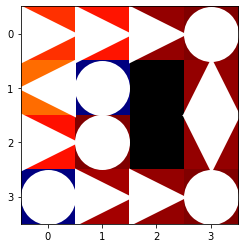

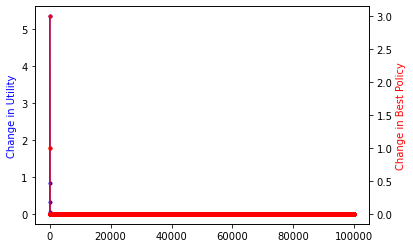

Final result of QLearning:
[[1. 0. 1. 3.]
 [3. 0. 0. 2.]
 [0. 0. 2. 1.]
 [3. 0. 3. 1.]]
[[ 0.65595494  1.06011706  1.3465906   0.41485827]
 [ 0.02698597  0.31083399  0.13682245  0.4652267 ]
 [-0.0873457   0.32685467  0.51489515  0.22032966]
 [ 0.47026618  0.26215172  0.60378687 -0.17519517]]


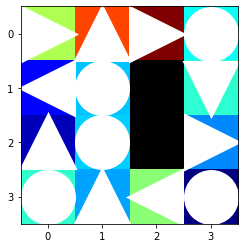

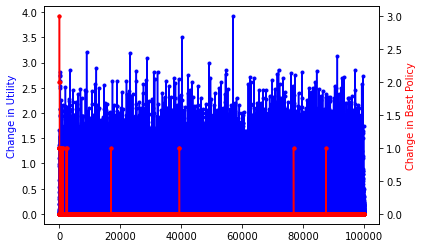

In [6]:
# 迭代次数调整 1

default_reward = -0.03
learning_rate = 0.8
iterations = 100000 # 调大
MainProgram(default_reward,learning_rate,iterations)

Final result of Value Iteration:
[[1. 1. 1. 0.]
 [3. 0. 1. 0.]
 [1. 0. 3. 2.]
 [0. 1. 1. 0.]]
[[ 0.6589372   0.71111111  0.9625      1.        ]
 [ 0.54154589 -1.          0.9625      0.9625    ]
 [ 0.72415459  1.          0.99583333  0.9625    ]
 [-1.          0.93333333  0.9625      1.        ]]


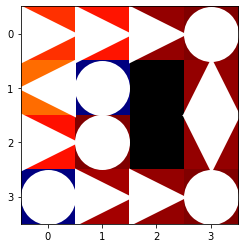

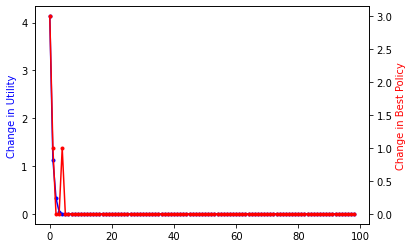

Final result of Policy Iteration:
[[1. 1. 1. 0.]
 [3. 0. 1. 0.]
 [1. 0. 3. 2.]
 [0. 1. 1. 0.]]
[[ 0.6589372   0.71111111  0.9625      1.        ]
 [ 0.54154589 -1.          0.9625      0.9625    ]
 [ 0.72415459  1.          0.99583333  0.9625    ]
 [-1.          0.93333333  0.9625      1.        ]]


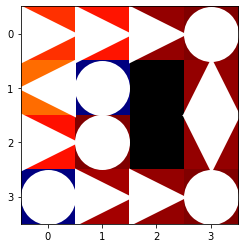

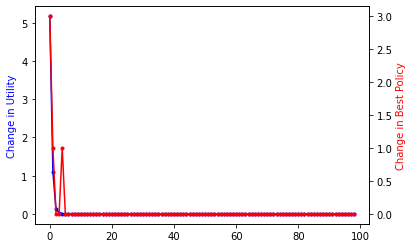

Final result of QLearning:
[[0. 1. 1. 2.]
 [3. 0. 3. 3.]
 [0. 3. 0. 1.]
 [1. 3. 2. 0.]]
[[ 1.00781548  1.453275    1.66797902  0.74273682]
 [-0.09618214  0.46990349  0.1422911   0.45612353]
 [-0.09516452  0.29100555  0.38535956  0.59343046]
 [ 0.39474908  0.25846671  0.30253642  0.41533328]]


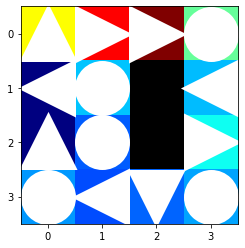

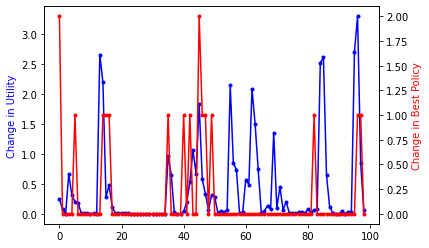

In [7]:
# 迭代次数调整 2

default_reward = -0.03
learning_rate = 0.8
iterations = 100 # 调小
MainProgram(default_reward,learning_rate,iterations)

#### 迭代次数调整 规律发现

最开始是调大迭代次数，决策的结果基本没变化，因为智能体早已比较收敛。

*Q-learning*在20000,40000,80000次左右还有四次策略调整，但已经没有决定性变化。

后来调小了迭代次数，更好的观察到了训练早期的调整过程，发现最开始调整的程度比较大，收敛速度比较快，而后来收敛速度就逐渐变慢了，调整也少了，因为离最优解越来越近了。

对于*Q-learning*，可以看到10000次相对于100次还是有很多提升：比如$(3,1),(3,2),(2,3)$,的决策更加合理，从颜色深浅的可视化上看，随着迭代次数增加，智能体越来越肯定自己的决策了。

Final result of QLearning:
[[1. 0. 1. 0.]
 [3. 2. 3. 3.]
 [0. 3. 1. 3.]
 [2. 1. 0. 1.]]
[[ 0.30786954  0.54863866  1.28194638  0.32015852]
 [ 0.11433744  0.1005961  -0.05582153  0.79969693]
 [-0.03982693  0.30714201  0.44207664  0.20679548]
 [-0.02936203  0.81074521  0.36460852  0.2724429 ]]


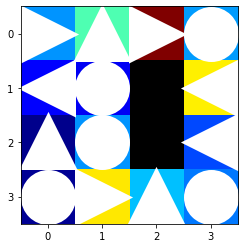

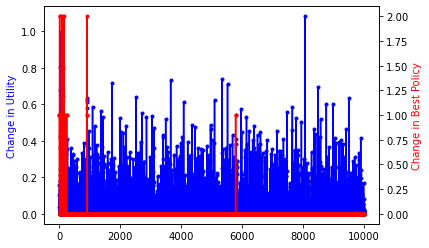

In [9]:
# Q-learning 学习率调整 1 

default_reward = -0.03
learning_rate = 0.4 # 更小学习率
iterations = 10000
MainProgram(default_reward,learning_rate,iterations,OnlyQlearning=True)

Final result of QLearning:
[[0. 0. 1. 0.]
 [3. 1. 3. 2.]
 [0. 1. 2. 2.]
 [2. 2. 1. 2.]]
[[ 1.7742185   1.31847561  1.53615573  0.59572846]
 [-0.2962731   0.26710732  0.26196369  0.27860331]
 [-0.18354931  0.06608134  0.25322451  0.2351226 ]
 [ 0.45756462  0.28578418  0.40462205 -0.06187965]]


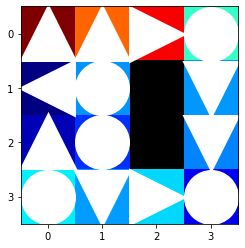

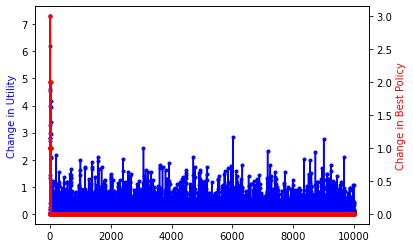

In [10]:
# 学习率调整 2

default_reward = -0.03
learning_rate = 1.2 # 更大学习率
iterations = 10000
MainProgram(default_reward,learning_rate,iterations,OnlyQlearning=True)

#### *Q-learing* 学习率调整 规律发现

学习率变小，每次调整的改变就越小，收敛会变得更慢，对于决策的肯定性也没那么高，图中可以看到，在更高的迭代次数时，仍有最佳策略的变化。

学习率调大，收敛变快，在不到500以后就没有策略变化了，从结果看，甚至比对照组10000次迭代后的策略更合理。


Final result of Value Iteration:
[[1. 2. 1. 0.]
 [1. 0. 3. 0.]
 [1. 0. 3. 2.]
 [0. 0. 1. 0.]]
[[-5.74881517 -3.52488152 -1.5         1.        ]
 [-3.54028436 -1.         -1.05555556 -1.5       ]
 [-1.65402844  1.          0.72222222 -1.5       ]
 [-1.         -1.45       -1.5         1.        ]]


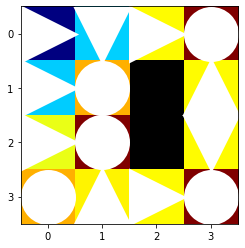

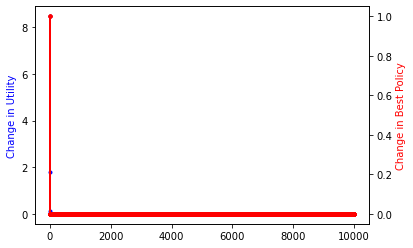

Final result of Policy Iteration:
[[1. 2. 1. 0.]
 [1. 0. 3. 0.]
 [1. 0. 3. 2.]
 [0. 0. 1. 0.]]
[[-5.74881517 -3.52488152 -1.5         1.        ]
 [-3.54028436 -1.         -1.05555556 -1.5       ]
 [-1.65402844  1.          0.72222222 -1.5       ]
 [-1.         -1.45       -1.5         1.        ]]


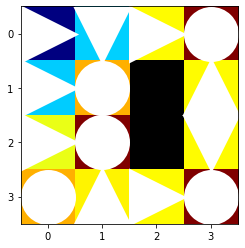

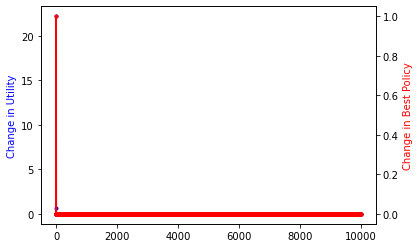

Final result of QLearning:
[[1. 1. 1. 0.]
 [2. 3. 1. 1.]
 [2. 0. 2. 3.]
 [1. 3. 3. 1.]]
[[-2.88139348 -1.13695315  1.35510755  0.54124955]
 [-2.64465135  0.47559037  0.36286596  0.22405623]
 [-0.71688703  0.53468161  0.09026252  0.28563776]
 [ 0.31454496  0.40871718  0.68890203  0.20233116]]


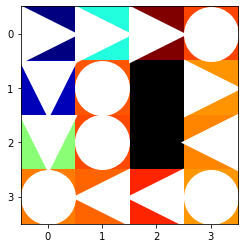

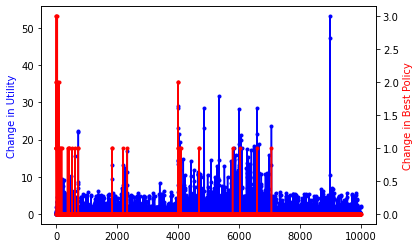

In [11]:
# 默认奖励调整 1

default_reward = -2 # 小于陷阱的惩罚
learning_rate = 0.8
iterations = 10000 
MainProgram(default_reward,learning_rate,iterations)

Final result of Value Iteration:
[[0. 0. 3. 0.]
 [3. 0. 1. 2.]
 [0. 0. 1. 0.]
 [0. 1. 3. 0.]]
[[ 2.00000000e+04  2.00000000e+04  2.00000000e+04  1.00000000e+00]
 [ 1.80023000e+04 -1.00000000e+00  1.99977778e+04  2.00000000e+04]
 [ 1.60026000e+04  1.00000000e+00  1.77806358e+04  2.00000000e+04]
 [-1.00000000e+00  4.10000000e+01  4.35000000e+01  1.00000000e+00]]


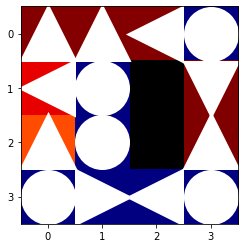

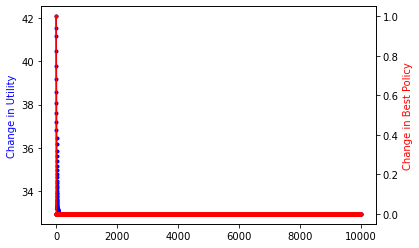

Final result of Policy Iteration:
[[0. 0. 3. 0.]
 [3. 0. 1. 2.]
 [0. 0. 1. 0.]
 [0. 1. 3. 0.]]
[[ 2.00020000e+04  2.00020000e+04  2.00020000e+04  1.00000000e+00]
 [ 1.80041000e+04 -1.00000000e+00  1.99996889e+04  2.00019000e+04]
 [ 1.60042000e+04  1.00000000e+00  1.77823247e+04  2.00019000e+04]
 [-1.00000000e+00  4.10000000e+01  4.35000000e+01  1.00000000e+00]]


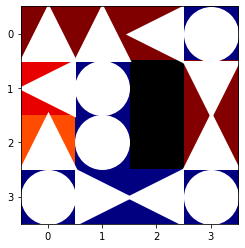

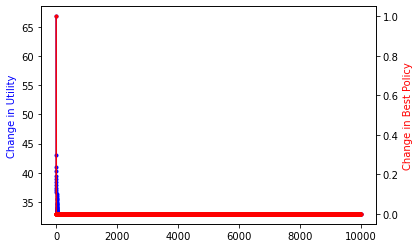

KeyboardInterrupt: 

In [12]:
# 默认奖励调整 2

default_reward = 2 # 大于奖励的加分
learning_rate = 0.8
iterations = 10000
MainProgram(default_reward,learning_rate,iterations)


#### 默认奖励调整 规律发现

1.默认惩罚狠于陷阱：

此时走一般的格子还不入走陷阱，走陷阱扣的分还更少，*Value & Policy Iteration* 的结果都是优先朝着陷阱走去。

*Q-learning*的结果是优先朝着奖励走去，还是避开陷阱，这样的最终收益更大：虽然沿途都是荆棘，但还是朝远处的蛋糕走去，而不是优先去“陷阱”短暂的放松。

2.默认奖励大于奖励：

只要不进陷阱，就能加分，奖励点的诱惑力减少了，结果是：很难得到最佳决策，这些格子都能加分，*Q-learning*迟迟不收敛，20min后仍无法得到结果。

默认奖励的初心是督促智能体必须移动，最好设置于负值，不然他就可以摆烂了，也不能太小，否则可能会倾向于进入陷阱。


### Summary

在Grid World 中，我尝试了调整参数，在已有的程序上运行Q-Learning算法，并观察了智能的“软件小机器人”是否可以达到目的地，以及路径、在各个点的决策方向。通过控制变量和对比实验，得到了上述规律，也符合实际逻辑。


## Summary

第二次课程设计尝试了一个强化学习的小程序，通过实践、调整参数，我对马尔科夫过程、Bellman Equation和Q-Learning有了更深入的理解。

## References

https://copyfuture.com/blogs-details/20200320113725944awqrghbojzsr9ce

https://zoo.cs.yale.edu/classes/cs470/materials/hws/hw7/FrozenLake.html

https://github.com/bengboom/ReforanceLearningProjects/tree/main/%E5%86%B0%E6%B9%96%E9%97%AE%E9%A2%98





